In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

import pandas as pd
import plotly.graph_objs as go
from lifelines import KaplanMeierFitter
import plotly
plotly.offline.init_notebook_mode(connected=True)
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Logistic Hazard Model

In [58]:
final_df = pd.read_csv('final_preoperative_dataset_ids.csv')

In [59]:
nn_dataset = final_df.loc[(final_df['KPSpre'].notnull()) 
                     & (final_df['ENTvolML'].notnull()) 
                     & (final_df['ENTside'].notnull())]

In [60]:
with open('../data/pickles_jsons/filter_ids_v2_all.pkl', 'rb') as file:
    filter_ids = pickle.load(file)

In [61]:
nn_dataset = nn_dataset.loc[~nn_dataset['ID'].isin(filter_ids), :]

In [62]:
print("Total Patients: {}".format(len(nn_dataset)))

Total Patients: 1016


In [ ]:
nn_dataset.loc[nn_dataset['surv'] < 66]

In [14]:
# nn_dataset = nn_dataset.drop('age', axis=1)

In [64]:
nn_dataset.loc[:, 'ENTside'] = nn_dataset['ENTside'].apply(lambda x: 1 if x == 'R' else 0)
nn_dataset.loc[:, 'DeathObserved'] = nn_dataset['DeathObserved'].apply(lambda x: 1 if x is True else 0)
nn_dataset.loc[:, 'Chemo'] = nn_dataset['Chemo'].apply(lambda x: 1 if x is True else 0)
nn_dataset.loc[:, 'GenderV2'] = nn_dataset['GenderV2'].apply(lambda x: 1 if x == 'Female' else 0)

In [ ]:
nn_dataset

# Descriptives

In [ ]:
nn_dataset.loc[nn_dataset['GenderV2'] == 0]

In [ ]:
nn_dataset.describe()

# Crosstabs MRI sequences

In [19]:
subjects_df_orig = pd.read_csv('../data/all_subjects.csv').drop('Unnamed: 0', axis=1)

In [20]:
experiments_df = pd.read_csv('../data/all_experiments.csv').drop('Unnamed: 0', axis=1)

In [24]:
experiments_df_filtered = experiments_df.loc[experiments_df['subjectID'].isin(nn_dataset['ID']) & experiments_df['preop'] == True].drop_duplicates('subjectID')

In [25]:
experiments_df_filtered['hospital'] = experiments_df_filtered['subjectID'].apply(lambda x: subjects_df_orig.loc[subjects_df_orig['ID'] == x, 'group'].tolist()[0])

In [26]:
experiments_df_filtered.drop(experiments_df_filtered.columns.difference(['flr','t1c', 't1w', 't2w', 'hospital']), 1, inplace=True)

In [27]:
experiments_df_filtered['flr'] = experiments_df_filtered['flr'].apply(lambda x: True if pd.isna(x) else False)
experiments_df_filtered['t1c'] = experiments_df_filtered['t1c'].apply(lambda x: True if pd.isna(x) else False)
experiments_df_filtered['t1w'] = experiments_df_filtered['t1w'].apply(lambda x: True if pd.isna(x) else False)
experiments_df_filtered['t2w'] = experiments_df_filtered['t2w'].apply(lambda x: True if pd.isna(x) else False)

In [28]:
experiments_df_filtered['count'] = experiments_df_filtered.count(axis=1)

In [29]:
counts_missing_modalities = experiments_df_filtered.groupby(['flr','t1c', 't1w', 't2w','hospital']).size().reset_index().rename(columns={0:'count'}).sort_values('hospital')

In [30]:
counts_missing_modalities

,flr,t1c,t1w,t2w,hospital,count
30,True,False,False,True,ETZ,9
42,True,False,True,True,ETZ,130
22,False,False,True,True,ETZ,2
10,False,False,False,True,ETZ,3
0,False,False,False,False,HMC,4
38,True,False,True,False,HMC,13
43,True,False,True,True,HMC,84
23,False,False,True,True,HMC,1
1,False,False,False,False,HUM,6
24,False,False,True,True,HUM,2


In [31]:
counts_missing_modalities.groupby('hospital').sum().reset_index().sort_values('hospital')

,hospital,flr,t1c,t1w,t2w,count
0,ETZ,2,0,2,4,144
1,HMC,2,0,3,2,102
2,HUM,0,0,1,2,74
3,ISALA,2,0,1,2,29
4,MUW,3,0,3,2,85
5,NWZ,1,0,2,2,36
6,PARIS,2,0,3,4,65
7,SLZ,1,0,1,1,5
8,UCSF,3,0,3,3,132
9,UMCG,4,0,3,3,83


# Data Split

In [65]:
with open('../data/pickles_jsons/ids_per_phase.pkl', 'rb') as file:
    phase_id_dict = pickle.load(file)

In [ ]:
df_train = nn_dataset.loc[nn_dataset['ID'].isin(phase_id_dict['train'])]
sorterIndex_train = dict(zip(phase_id_dict['train'], range(len(phase_id_dict['train']))))
df_train['rank'] = df_train['ID'].map(sorterIndex_train)
df_train.sort_values(['rank'], ascending = [True], inplace = True)
df_train.drop('rank', 1, inplace = True)

df_test = nn_dataset.loc[nn_dataset['ID'].isin(phase_id_dict['test'])]
sorterIndex_test = dict(zip(phase_id_dict['test'], range(len(phase_id_dict['test']))))
df_test['rank'] = df_test['ID'].map(sorterIndex_test)
df_test.sort_values(['rank'], ascending = [True], inplace = True)
df_test.drop('rank', 1, inplace = True)

df_val = nn_dataset.loc[nn_dataset['ID'].isin(phase_id_dict['val'])]
sorterIndex_val = dict(zip(phase_id_dict['val'], range(len(phase_id_dict['val']))))
df_val['rank'] = df_val['ID'].map(sorterIndex_val)
df_val.sort_values(['rank'], ascending = [True], inplace = True)
df_val.drop('rank', 1, inplace = True)

In [ ]:
df_train.head(1)

In [ ]:
df_val.head(1)

## Preprocessing

In [67]:
cols_standardize = ['age', 'ENTvolML', 'KPSpre']
# cols_standardize = ['ENTvolML', 'KPSpre'] #without age
cols_leave = ['ENTside', 'GenderV2', 'Chemo', 'SurgeryExtend']
# cols_leave = ['ENTside', 'Chemo', 'SurgeryExtend']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

### Train/test/val split

In [68]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.fit_transform(df_test).astype('float32')
x_val = x_mapper.fit_transform(df_val).astype('float32')

In [69]:
len(x_train), 

(711,)

In [ ]:
df_train

In [70]:
num_cuts = 10
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_cuts, scheme)

get_target = lambda df: (df['surv'].values, df['DeathObserved'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.transform(*get_target(df_test))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

In [71]:
labtrans.cuts

array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829.,
       1785.])

In [72]:
trace = go.Scatter(x=kaplan_meier(*get_target(df_train)).index.tolist(), y=kaplan_meier(*get_target(df_train)).values.tolist(), mode='lines', name='Kaplan-Meier')

shapes = list()
for i in (labtrans.cuts):
    shapes.append({'type': 'line',
                   'xref': 'x',
                   'yref': 'y',
                   'x0': i,
                   'y0': 0,
                   'x1': i,
                   'y1': 1,
                   'line': {'dash': 'dash'}})
    
layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(-99, 1900),
                
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,
    height=500, 
    autosize=False,
    shapes = shapes)


# layout = plotly.graph_objs.Layout(shapes=shapes)
fig = go.Figure([trace], layout=layout)

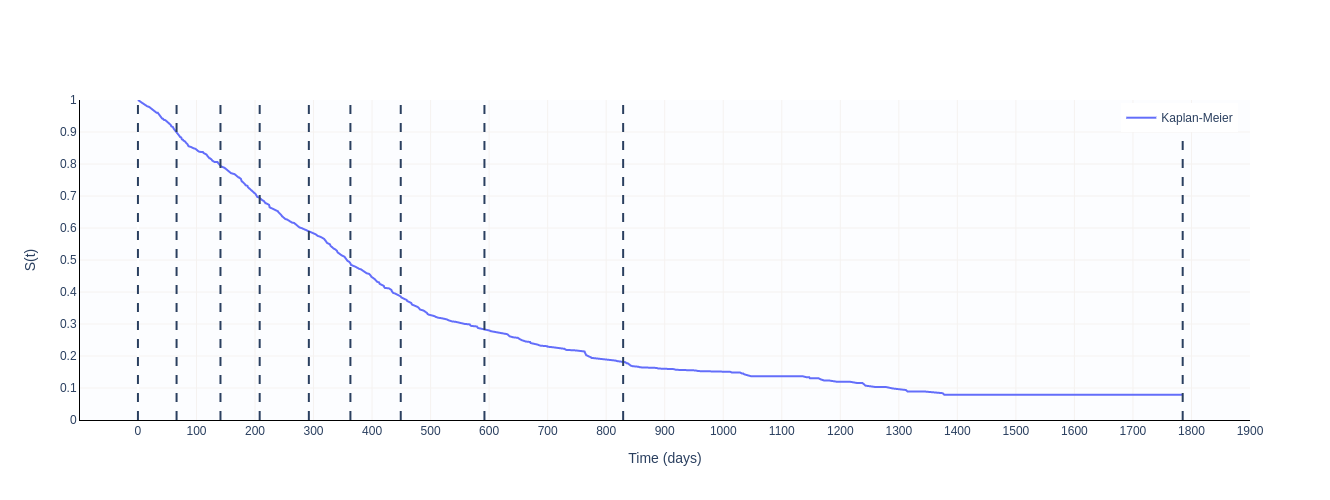

In [73]:
fig

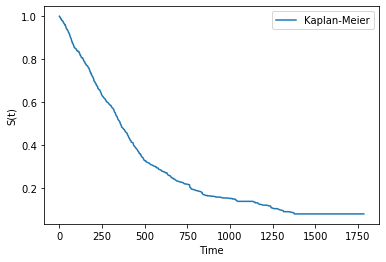

In [47]:
from pycox.utils import kaplan_meier
# plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

## Kaplan Meier

In [74]:
km_train = kaplan_meier(*get_target(df_train))
km_val = kaplan_meier(*get_target(df_test))
km_test = kaplan_meier(*get_target(df_test))

In [75]:
km_test.to_csv('../data/km_test.csv')

In [76]:
data = [[km_train, 'train'], [km_val, 'val'], [km_test, 'test']]
traces = []
for phase in data:
    trace = go.Scatter(x=phase[0].index.tolist(), y=phase[0].values.tolist(), name=phase[1])
    traces.append(trace)
    
layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure(traces, layout=layout)

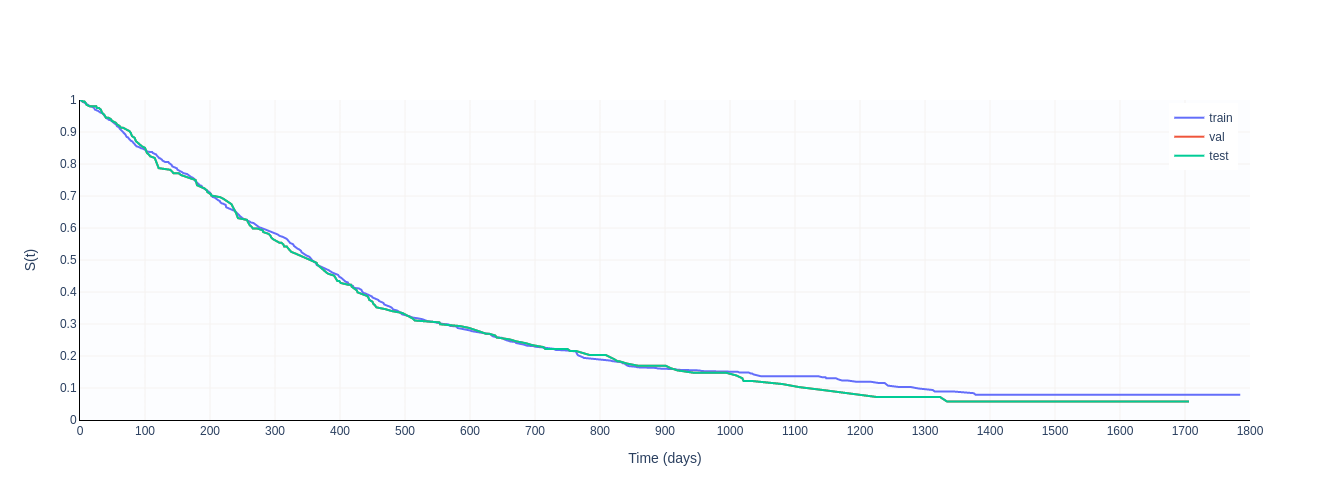

In [77]:
fig

In [78]:
per_group_idx = {}
for i, group in enumerate(y_test[0]):
    if group in per_group_idx.keys():
        per_group_idx[group].append(i)
    else:
        per_group_idx[group] = [i]

In [79]:
per_group_km = {}
for group in per_group_idx.keys():
    indexes = per_group_idx[group]
    survs = get_target(df_test)[0][indexes]
    events = get_target(df_test)[1][indexes]
    per_group_km[group] = (survs, events)

In [80]:
labtrans.cuts

array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829.,
       1785.])

In [81]:
# colors = ['rgb(166,206,227)','rgb(31,120,180)','rgb(178,223,138)','rgb(51,160,44)','rgb(251,154,153)','rgb(227,26,28)','rgb(253,191,111)','rgb(255,127,0)','rgb(202,178,214)','rgb(106,61,154)']
colors = ['rgb(103,0,31)','rgb(178,24,43)','rgb(214,96,77)','rgb(244,165,130)','rgb(253,219,199)','rgb(209,229,240)','rgb(146,197,222)','rgb(67,147,195)','rgb(33,102,172)','rgb(5,48,97)']

traces = []
for i in range(0,9):
    trace = go.Scatter(x=kaplan_meier(*per_group_km[i]).index.tolist(), 
                       y=kaplan_meier(*per_group_km[i]).values.tolist(), 
                       name='{} days'.format(int(labtrans.cuts[i])),
                      mode='lines',
                      line_color=colors[i])
    traces.append(trace)
layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 252, 252)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 900),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_title='Discrete time',
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=1.3,
    width=500,height=500, autosize=False)
fig = go.Figure(traces, layout=layout)

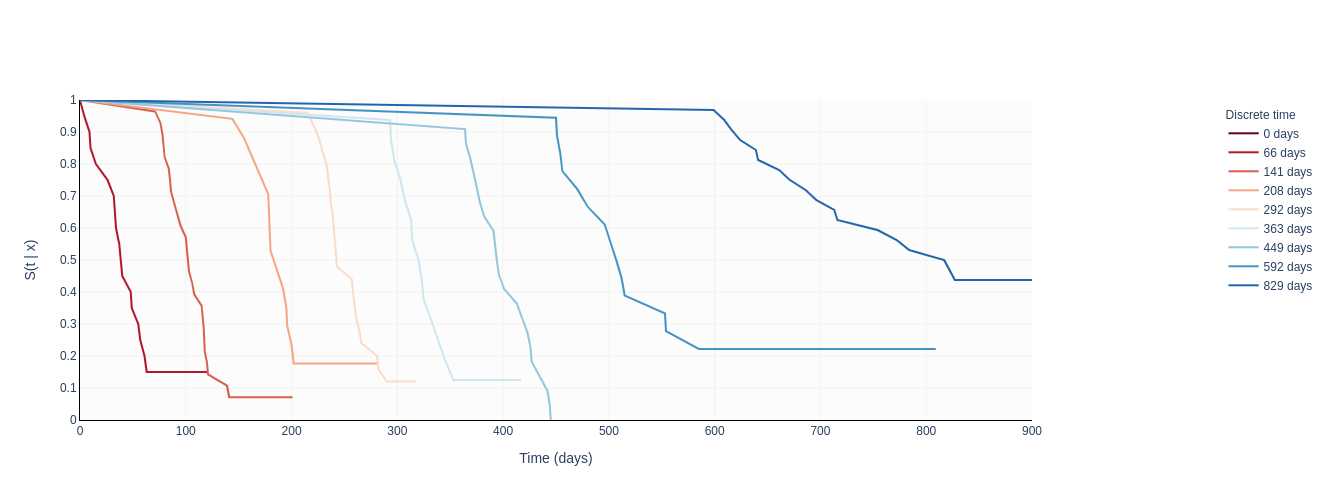

In [82]:
fig

## Neural Network Run

In [83]:
from pycox.models import LogisticHazard

In [84]:
labtrans.cuts

array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829.,
       1785.])

### Model

In [85]:
input_features = x_train.shape[1]
output_features = labtrans.out_features
dropout = 0.7

net = torch.nn.Sequential(
    torch.nn.Linear(input_features, 28),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(28),
    torch.nn.Dropout(0.8),
    
    torch.nn.Linear(28, 56),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(56),
    
    torch.nn.Linear(56, 56),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(56),
#     torch.nn.Dropout(dropout),
    
    torch.nn.Linear(56, 112),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(112),
    torch.nn.Dropout(0.8),
    
    torch.nn.Linear(112, output_features)
)

In [86]:
net

Sequential(
  (0): Linear(in_features=7, out_features=28, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.8, inplace=False)
  (4): Linear(in_features=28, out_features=56, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=56, out_features=56, bias=True)
  (8): ReLU()
  (9): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=56, out_features=112, bias=True)
  (11): ReLU()
  (12): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Dropout(p=0.8, inplace=False)
  (14): Linear(in_features=112, out_features=10, bias=True)
)

In [87]:
model = LogisticHazard(net, tt.optim.AdamWR(decoupled_weight_decay=0.05, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2), duration_index=labtrans.cuts)

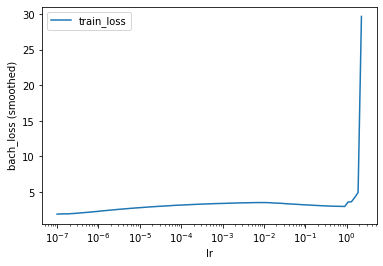

In [121]:
batch_size = 512
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [122]:
lrfind.get_best_lr()

0.0001

In [123]:
model.optimizer.set_lr(0.03)

### Load weights if wanted

In [88]:
model.load_model_weights('../Results/best_clinical/best_clinical_13-10.pt')

In [75]:
batch_size = 512
epochs = 10000
callbacks = [tt.cb.EarlyStopping(patience=1000)]

### Train if wanted

In [ ]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=(x_val, y_val), )

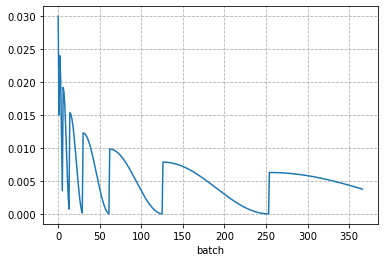

In [472]:
lrs = model.optimizer.lr_scheduler.to_pandas() * model.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.grid(linestyle='--')

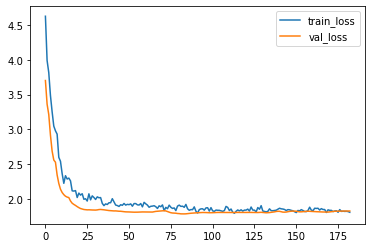

In [473]:
_ = log.plot()

In [471]:
log.to_pandas().val_loss.min()

1.7861186265945435

In [403]:
model.score_in_batches((x_val, y_val))

{'loss': 1.7861186265945435}

# Boxplot

In [242]:
trace = go.Box(y=data)
fig = go.Figure([trace])

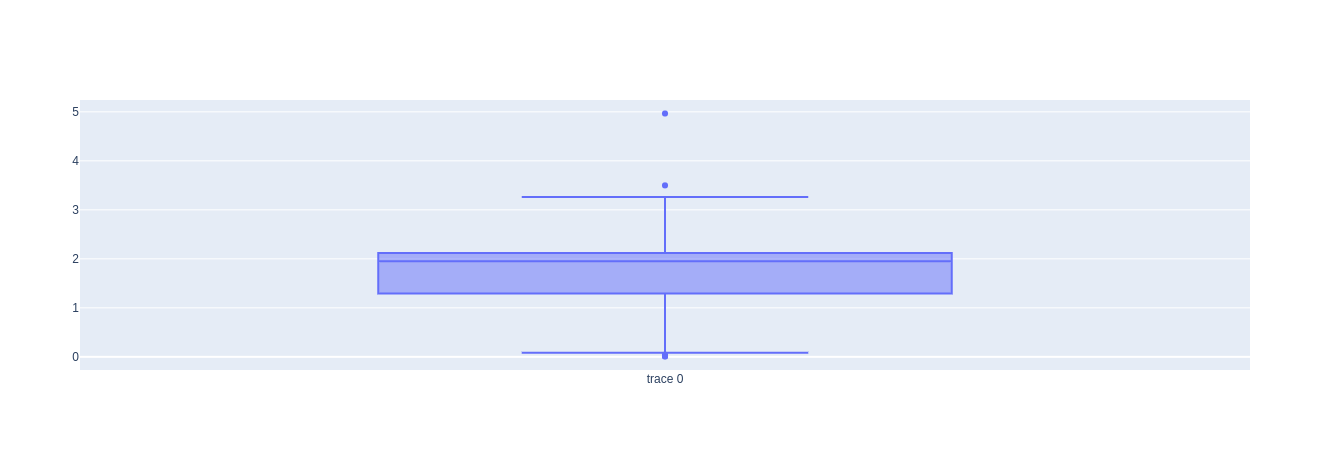

In [243]:
fig.show()

# Scatter plot

In [ ]:
trace = go.Scatter(x=list(range(len(data))), y=data, mode='markers', name='Subject loss', line_color='blue')
layout = go.Layout(title='Individual Loss of every patient in validation dataset', 
                   title_x=0.5, 
                   xaxis_range=(-0.5, 102), 
                   xaxis_tickmode = 'linear', 
                   xaxis_dtick = 5, 
                   xaxis_title='Subject', 
                   yaxis_title='Negative Log Likelihood',
                   plot_bgcolor='rgb(252, 253, 255)', 
                   xaxis_gridcolor='rgb(245, 242, 240)',
                   yaxis_gridcolor='rgb(245, 242, 240)',
                   yaxis_linecolor="black",
                   xaxis_linecolor="black",
                   yaxis_range=(-0.5, 7),
                   yaxis_tickmode = 'linear',
                   yaxis_dtick = 0.5,
                   width=600,height=500, autosize=False
                  )
trace2 = go.Scatter(x=list(range(len(data))), y=[np.array(data).mean()]*len(data), name='Mean Loss', line_color='red')
fig = go.Figure([trace2, trace], layout=layout)

In [ ]:
fig.show()

# Histogram

In [111]:
trace = go.Histogram(x=data.tolist(), xbins_size=0.25)
fig = go.Figure([trace])

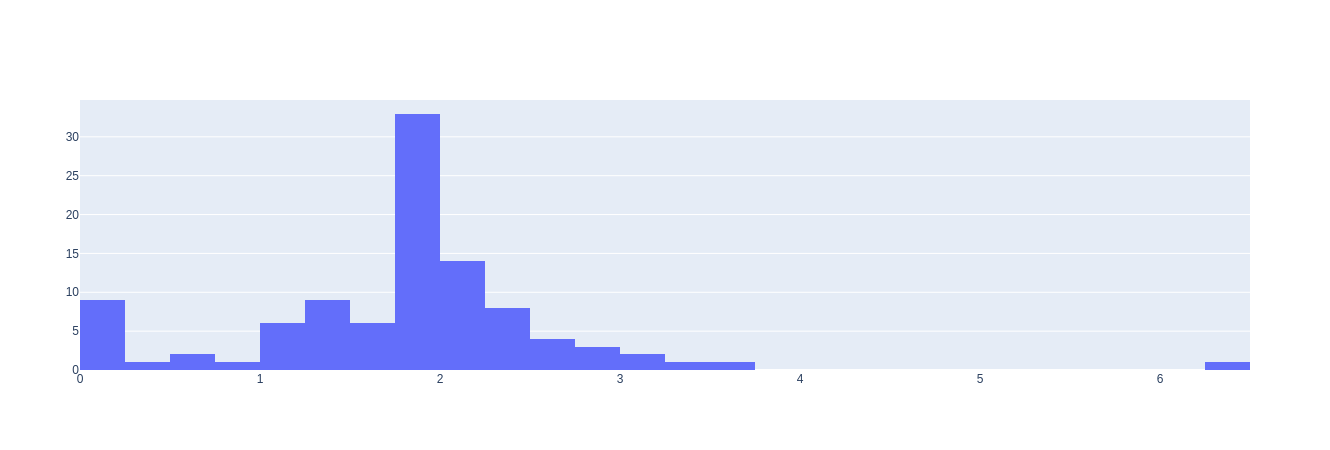

In [112]:
fig.show()

# Predictions

In [91]:
surv = model.predict_surv_df(x_test)

In [92]:
surv_interpolated = model.interpolate(10, 'const_hazard').predict_surv_df(x_test)

In [93]:
surv

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0.0,0.996447,0.999227,0.999257,0.999444,0.999569,0.999630,0.999190,0.997893,0.999496,0.996851,...,0.997698,0.996552,0.995951,0.999717,0.998932,0.999680,0.999576,0.996216,0.998966,0.998540
66.0,0.824587,0.982897,0.983553,0.987839,0.990158,0.991322,0.982078,0.684678,0.988845,0.851826,...,0.916566,0.825195,0.801396,0.992823,0.974903,0.992100,0.990300,0.732532,0.975540,0.959582
141.0,0.654402,0.945722,0.947409,0.957871,0.963977,0.967052,0.943693,0.415397,0.960479,0.699648,...,0.810751,0.650515,0.620981,0.971287,0.927014,0.969251,0.964348,0.502165,0.928295,0.892683
208.0,0.521760,0.867559,0.870283,0.888904,0.901027,0.908301,0.865032,0.262137,0.893467,0.552627,...,0.682675,0.494428,0.475475,0.920115,0.839209,0.914321,0.901660,0.346927,0.843182,0.786923
292.0,0.380230,0.784586,0.788475,0.815000,0.832934,0.843721,0.780839,0.143351,0.822109,0.403970,...,0.548203,0.346085,0.330523,0.859668,0.746486,0.851993,0.834030,0.211442,0.750793,0.678632
363.0,0.279951,0.660405,0.664920,0.698032,0.721870,0.739577,0.656701,0.104990,0.706718,0.299343,...,0.423783,0.252986,0.240676,0.763412,0.620105,0.752464,0.724176,0.151754,0.623294,0.549129
449.0,0.208027,0.522313,0.526596,0.559385,0.582350,0.601991,0.519848,0.075173,0.566929,0.220628,...,0.319244,0.185337,0.176732,0.628592,0.486626,0.616614,0.584855,0.110080,0.491301,0.423756
592.0,0.131964,0.369759,0.373650,0.404230,0.425958,0.447453,0.368377,0.038206,0.410696,0.138416,...,0.209830,0.113963,0.109247,0.475684,0.341618,0.463437,0.429014,0.061838,0.345947,0.291612
829.0,0.074155,0.234681,0.237980,0.263937,0.282546,0.302125,0.234058,0.020778,0.268897,0.075427,...,0.119130,0.062281,0.059786,0.328481,0.212189,0.316699,0.285212,0.033973,0.215954,0.174929
1785.0,0.006487,0.001572,0.001530,0.001302,0.001175,0.001094,0.001614,0.005623,0.001241,0.005782,...,0.004130,0.006073,0.006760,0.001013,0.001967,0.001051,0.001149,0.006401,0.001965,0.002662


## Hazards

In [94]:
predictions_hazards = model.predict_hazard(x_test)
predictions_hazards_df = pd.DataFrame(predictions_hazards).T
predictions_hazards_df.index = labtrans.cuts

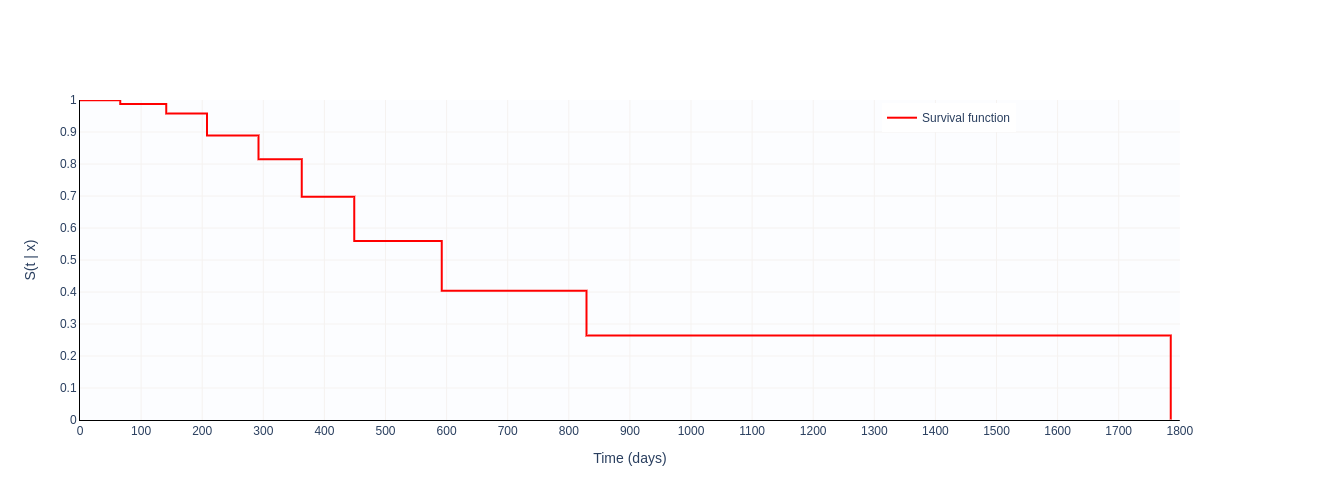

In [95]:
from plotly.subplots import make_subplots
# trace1 = go.Scatter(x=predictions_hazards_df.iloc[:, 3].index.tolist(), y=predictions_hazards_df.iloc[:, 3].values.tolist(), mode='lines', line_shape='hv', name='Hazard function')
trace2 = go.Scatter(x=surv.iloc[:, 3].index.tolist(), y=surv.iloc[:, 3].values.tolist(), mode='lines', line_shape='hv', name='Survival function', line_color='red')    

layout = go.Layout(
#     title='Survival and hazard function of random patient', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
                
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.80,
    width=500,height=500, autosize=False)

fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.update_layout(
#     layout
# )
# fig = go.Figure([trace1], layout=layout)
fig.add_trace(trace2)
# fig.add_trace(trace2, secondary_y=True)
# fig.update_yaxes(title_text="S(t | x)", secondary_y=True)
fig.update_layout(
    layout
)

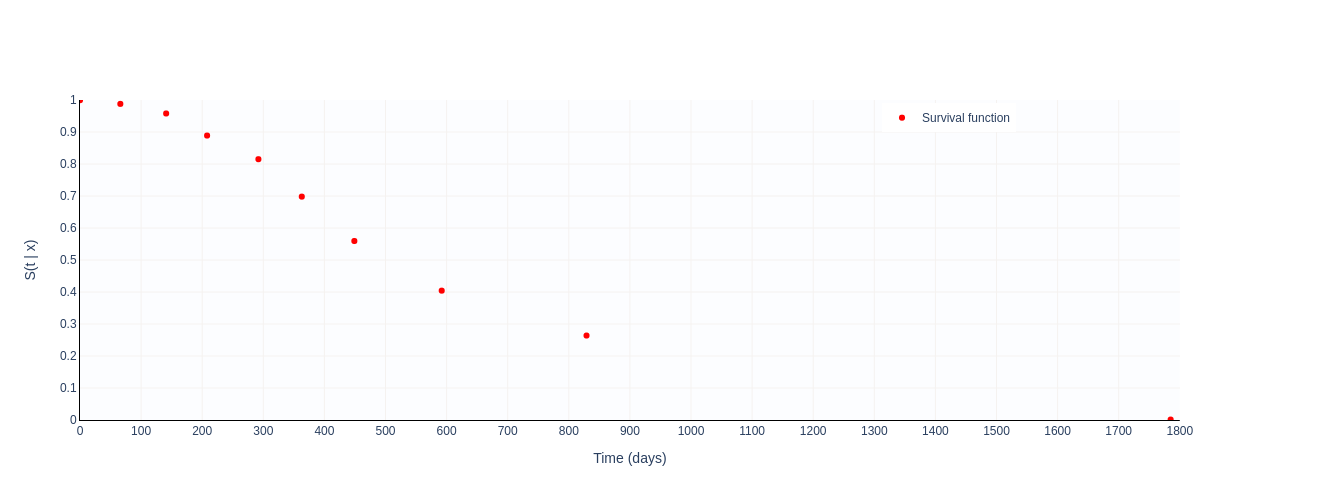

In [96]:
from plotly.subplots import make_subplots
# trace1 = go.Scatter(x=predictions_hazards_df.iloc[:, 3].index.tolist(), y=predictions_hazards_df.iloc[:, 3].values.tolist(), mode='lines', line_shape='hv', name='Hazard function')
trace2 = go.Scatter(x=surv.iloc[:, 3].index.tolist(), y=surv.iloc[:, 3].values.tolist(), mode='markers', name='Survival function', line_color='red')    

layout = go.Layout(
#     title='Survival and hazard function of random patient', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
                
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.80,
    width=500,height=500, autosize=False)

fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.update_layout(
#     layout
# )
# fig = go.Figure([trace1], layout=layout)
fig.add_trace(trace2)
# fig.add_trace(trace2, secondary_y=True)
# fig.update_yaxes(title_text="S(t | x)", secondary_y=True)
fig.update_layout(
    layout
)

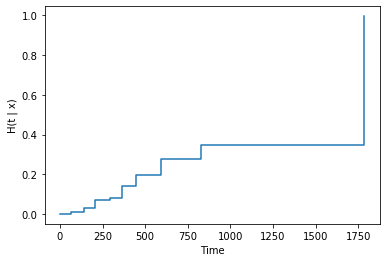

In [87]:
predictions_hazards_df.iloc[:, 3].plot(drawstyle='steps-post')
plt.ylabel('H(t | x)')
_ = plt.xlabel('Time')

In [76]:
y_test_targets = y_test[0]

In [405]:
test = {}
for integer in y_test[0]:
    if integer not in test.keys():
        test[integer] = integer
    else:
        test[integer] += 1

In [407]:
percentages_test = {}
for key, value in zip(test.keys(), test.values()):
    percentage = (value/204)*100
    percentages_test[key] = percentage

In [408]:
percentages_test

{7: 11.76470588235294,
 4: 13.725490196078432,
 8: 19.11764705882353,
 9: 10.784313725490197,
 3: 9.313725490196079,
 2: 14.215686274509803,
 6: 13.23529411764706,
 5: 9.803921568627452,
 0: 5.392156862745098,
 1: 9.803921568627452}

In [410]:
train = {}
for integer in y_train[0]:
    if integer not in train.keys():
        train[integer] = integer
    else:
        train[integer] += 1

In [412]:
percentages_train = {}
for key, value in zip(train.keys(), train.values()):
    percentage_train = (value/651)*100
    percentages_train[key] = percentage_train

In [413]:
percentages_train

{1: 13.671274961597543,
 8: 21.044546850998465,
 7: 12.288786482334869,
 3: 11.674347158218126,
 5: 10.75268817204301,
 6: 11.674347158218126,
 0: 3.3794162826420893,
 4: 11.367127496159753,
 2: 11.827956989247312,
 9: 6.912442396313365}

In [ ]:
df_val.reset_index().iloc[[26, 77, 49, 16, 34, 12, 45, 32, 100, 88]]

## Kaplan Meier total test sample (calibration)

In [97]:
trace1 = go.Scatter(x=surv.mean(axis=1).index.tolist(), y=surv.mean(axis=1).values.tolist(), mode='lines', line_shape='hv', name='Test sample predicted surv')
trace2 = go.Scatter(x=km_test.index.tolist(), y=km_test.values.tolist(), name='Test sample observed surv')    
# trace3 = go.Scatter(x=surv_interpolated.mean(axis=1).index.tolist(), y=surv_interpolated.mean(axis=1).values.tolist(), mode='lines', name='Test sample interpolated predicted surv')

layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
                
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure([trace1, trace2], layout=layout)

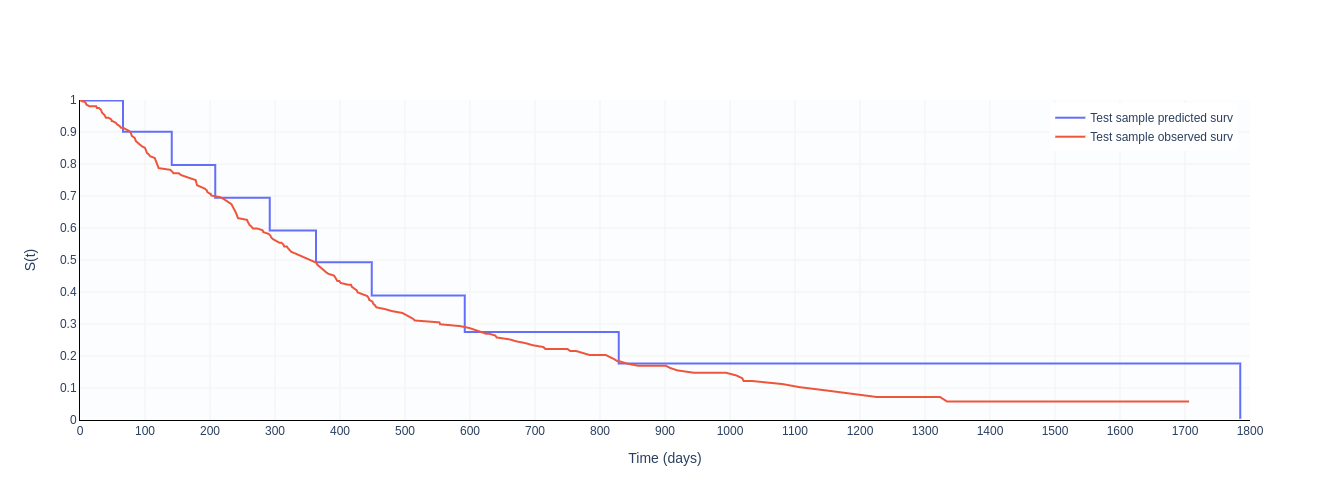

In [98]:
fig

In [256]:
trace1 = go.Scatter(x=surv_interpolated.mean(axis=1).index.tolist(), y=surv_interpolated.mean(axis=1).values.tolist(), mode='lines', name='Test sample predicted surv')
trace2 = go.Scatter(x=km_test.index.tolist(), y=km_test.values.tolist(), name='Test sample observed surv')    
fig = go.Figure([trace1, trace2], layout=layout)

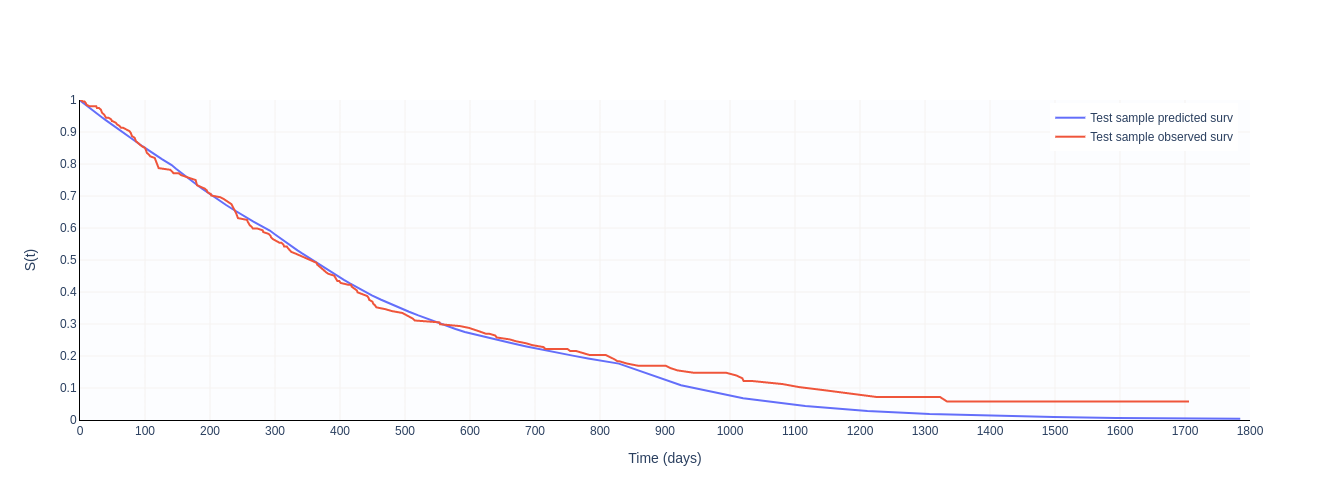

In [257]:
fig

# Investigate what happens past 825 days

In [261]:
df_train.loc[lambda x: x['surv'] > 1400]['DeathObserved'].mean()


0.0

In [316]:
test = tt.tuplefy(x_test, (durations_test, events_test))
data = test.iloc[(durations_test > 1400) & (events_test == 0)]
n = data[0].shape[0]

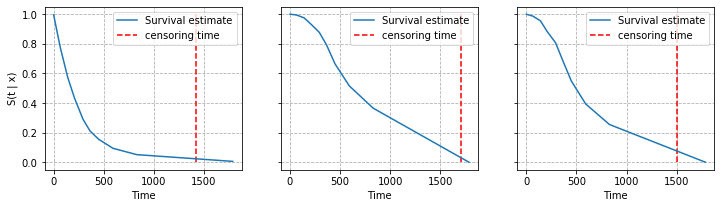

In [320]:
idx = np.random.choice(n, 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
for i, ax in zip(idx, axs.flat):
    x, (t, _) = data.iloc[[i]]
    surv = model.predict_surv_df(x)
    surv[0].rename('Survival estimate').plot(ax=ax)
    ax.vlines(t, 0, 1, colors='red', linestyles="--",
               label='censoring time')
    ax.grid(linestyle='--')
    ax.legend()
    ax.set_ylabel('S(t | x)')
    _ = ax.set_xlabel('Time')

In [368]:
durations_val = df_val.reset_index().iloc[[26, 77, 49, 16, 34, 12, 45, 32, 100, 88]]['surv'].tolist()

In [372]:
val = tt.tuplefy(x_val[[26, 77, 49, 16, 34, 12, 45, 32, 100, 88]], (np.array(durations_val), y_val[1][[26, 77, 49, 16, 34, 12, 45, 32, 100, 88]]))
# data = test.iloc[(durations_test > 1400) & (events_test == 0)]
n = val[0].shape[0]

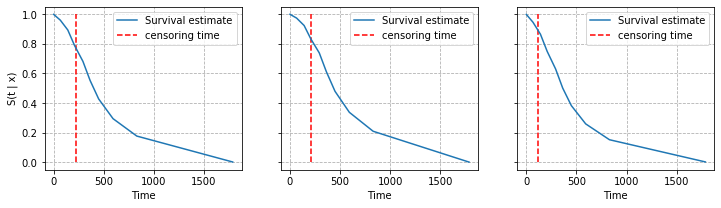

In [375]:
idx = np.random.choice(n, 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
for i, ax in zip(idx, axs.flat):
    x, (t, _) = val.iloc[[i]]
    surv = model.predict_surv_df(x)
    surv[0].rename('Survival estimate').plot(ax=ax)
    ax.vlines(t, 0, 1, colors='red', linestyles="--",
               label='censoring time')
    ax.grid(linestyle='--')
    ax.legend()
    ax.set_ylabel('S(t | x)')
    _ = ax.set_xlabel('Time')

# Average predicted Survival Curves

In [201]:
group_x = []
group_y = []
for i in range(10):
    idx = y_test_targets == i
    group_df = surv.loc[:, idx].mean(axis=1).rename(i)
    group_x.append(list(group_df.index))
    group_y.append(group_df.values)

In [207]:
# colors = ['rgb(166,206,227)','rgb(31,120,180)','rgb(178,223,138)','rgb(51,160,44)','rgb(251,154,153)','rgb(227,26,28)','rgb(253,191,111)','rgb(255,127,0)','rgb(202,178,214)','rgb(106,61,154)']
colors = ['rgb(103,0,31)','rgb(178,24,43)','rgb(214,96,77)','rgb(244,165,130)','rgb(253,219,199)','rgb(209,229,240)','rgb(146,197,222)','rgb(67,147,195)','rgb(33,102,172)','rgb(5,48,97)']

traces = []
for i in range(9):
    trace = go.Scatter(x=group_x[i], y=group_y[i], mode='markers', name='{} days'.format(int(labtrans.cuts[i])), line_color=colors[i], line_width=1.5)
    traces.append(trace)
    
layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 252, 252)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 900),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_title='Discrete time',
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure(traces, layout=layout)

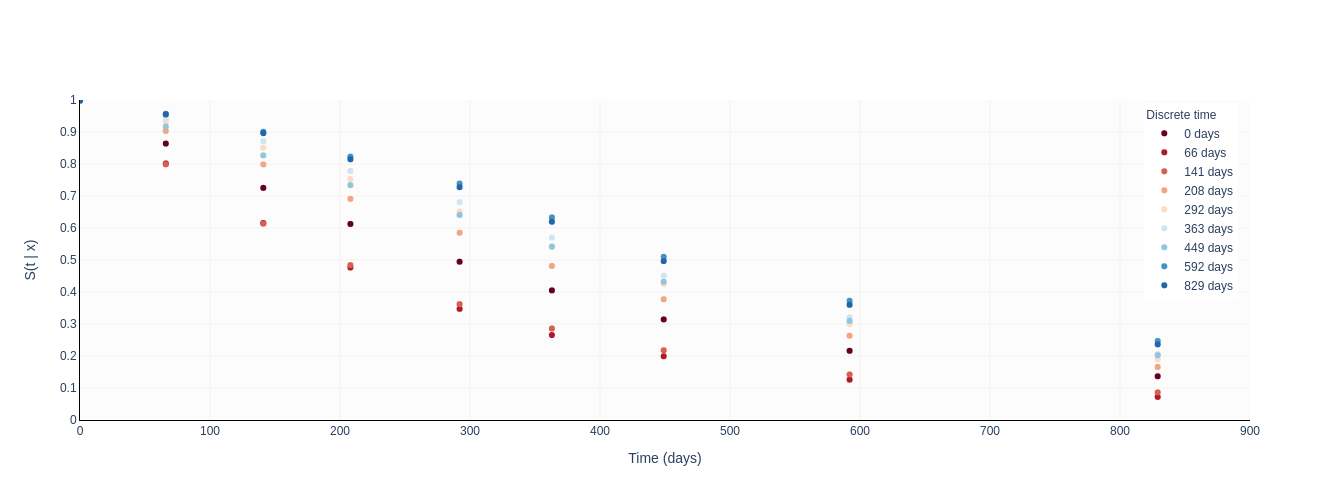

In [208]:
fig

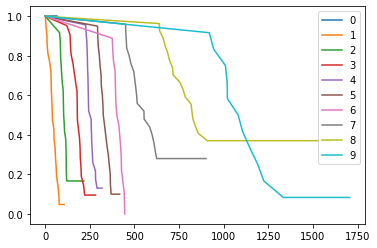

In [130]:
for i in range(10):
    idx = y_test[0] == i
    survs_pd = pd.DataFrame({'surv': df_test['surv'].tolist(), 'event': y_test[1]})
    durations = np.array(survs_pd.iloc[idx, 0])
    events_ = np.array(survs_pd.iloc[idx, 1])
    kaplan_meier(durations, events_).rename(i).plot()
    _ = plt.legend()

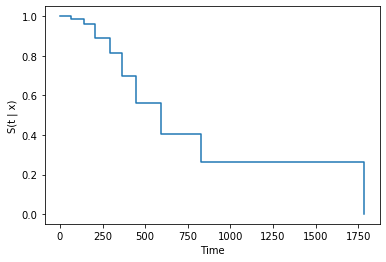

In [80]:
surv.iloc[:, 3].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Evaluation

## Discrete

In [99]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [100]:
ev.concordance_td('antolini')

0.6836376829120813

In [101]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [102]:
brier_score = ev.brier_score(time_grid)

In [39]:
pd.DataFrame(brier_score).to_csv('../data/predictions/clinical_brier_score.csv')

In [103]:
trace = go.Scatter(x=brier_score.index.tolist(), y=brier_score.values)
layout_brier = go.Layout(title='Brier score', 
                         title_x=0.5, xaxis_title='Time (days)', 
                         yaxis_title='Brier score',
                        plot_bgcolor='rgb(252, 253, 255)', 
                   xaxis_gridcolor='rgb(245, 242, 240)',
                  yaxis_gridcolor='rgb(245, 242, 240)',
                  yaxis_linecolor="black",
                  xaxis_linecolor="black",
                        xaxis_range=(0,1750),
                        xaxis_tickmode = 'linear',
        xaxis_dtick = 100)
fig_brier = go.Figure([trace], layout=layout_brier)

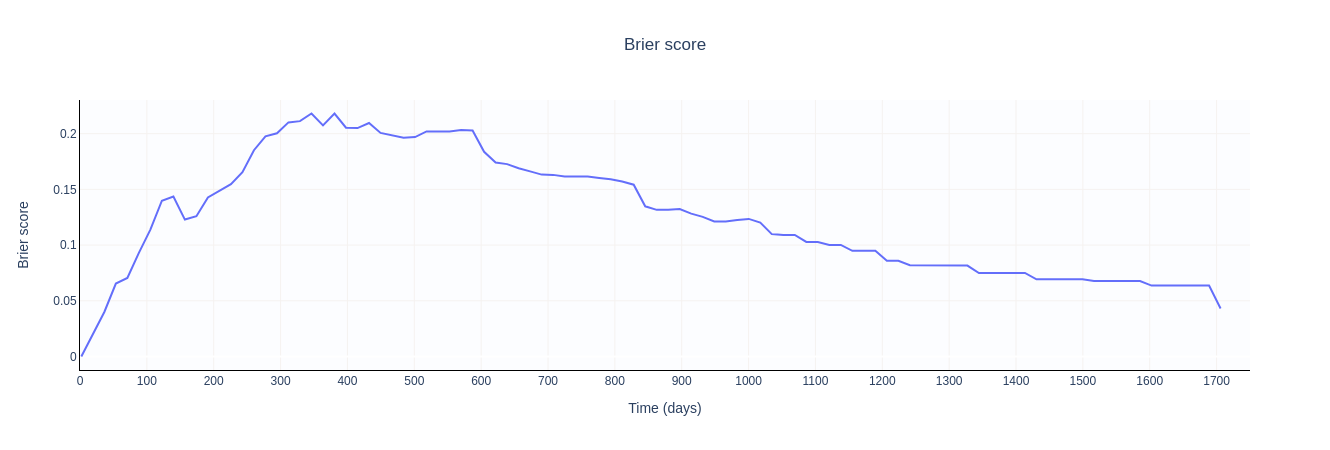

In [104]:
fig_brier

In [105]:
ev.integrated_brier_score(time_grid)

0.12591800948926923

## Interpolated

In [106]:
ev_inter = EvalSurv(surv_interpolated, durations_test, events_test, censor_surv='km')

In [107]:
ev_inter.concordance_td('antolini')

0.6964566453017293

In [108]:
ev_inter.integrated_brier_score(time_grid)

0.11870677416015463